<img src="../MHW_logo.png" width=250 alt="MHW Logo"></img>

# Marine Heatwave Detection
Marine heatwaves are periods of persistent anomalously warm ocean temperatures, which can have significant impacts on marine life as well as coastal communities and economies.
To detect the warm ocean water, sea surface temperature (SST) is usually used to define if there is any marine heatwave event.
The following example is following the paper [Jacox et al., 2022](http://doi.org/10.1038/s41586-022-04573-9)


---

## Overview

In this page/notebook, we will be go throught the following steps

1. Extract the data from the PSL OPeNDAP server
1. Calculate the SST climatology
1. Calculate the SST anomaly 
1. Determine the SST threshold based on the anomaly
1. Identify the marine heatwaves based on threshold 

## Prerequisites

To better understand and follow the steps in the notebook, it will be helpful for user to go through

| Concepts | Importance | Notes |
| --- | --- | --- |
| [Xarray](https://foundations.projectpythia.org/core/xarray.html) | Helpful | Chunking and OPeNDAP access |

- **Time to learn**: 15 minutes.
- **System requirements**:
    - python
    - Xarray
    - pydap (not imported but will be used in the Xarray backend)
    - matplotlib (not imported but will be used in the Xarray plotting)
    - Numpy

---

## Imports

In [1]:
# import the needed packages
import warnings
import xarray as xr
import numpy as np

In [2]:
warnings.simplefilter("ignore")

<div class="admonition alert alert-info">
    <p class="admonition-title" style="font-weight:bold">warnings.simplefilter</p>
    This line of code is not affecting the execution but just removing some of the warning output that might clutter your notebook. 
However, do pay attention to some of the warnings since they will indicate some deprecation of function or arg/kwarg in future update.
</div>

## Extract the data from an OPeNDAP server

In this page/notebook, we demonstrate how to use the [NOAA OISST v2 High-resolution dataset](https://psl.noaa.gov/data/gridded/data.noaa.oisst.v2.highres.html) to detect marine heatwaves.
The dataset is currently hosted by [NOAA Physical Sciences Laboratory](https://psl.noaa.gov/data/gridded).

<div class="admonition alert alert-info">
    <p class="admonition-title" style="font-weight:bold">Info</p>
    To explore more gridded datasets that are hosted at NOAA PSL, here is a useful 
    <a href="https://psl.noaa.gov/data/gridded/index.html">search tool</a>
</div>

In [3]:
opendap_mon_url = "https://psl.noaa.gov/thredds/dodsC/Datasets/noaa.oisst.v2.highres/sst.mon.mean.nc"

### Xarray getting remote data

Xarray has a great support on accessing data in the cloud. 
It has been continue to expend its capability and functionality with the community discussion like [this](https://github.com/pydata/xarray/issues/1068).
Here we use the `xr.open_dataset` method with the keyword argument (`engine='pydap'`) to use the pydap package in the backend to access the OPeNDAP server.

In [4]:
ds_mon = xr.open_dataset(opendap_mon_url, engine='pydap', chunks={'time':12,'lon':-1,'lat':-1})

<div class="admonition alert alert-success">
    <p class="admonition-title" style="font-weight:bold">Lazy Loading</p>
    We can load the data lazily (only loading the metadata and coordinates information) and 
    peek at the data's dimension and availability on our local machine. 
    The actual data (SST values at each grid point in this case) will only be downloaded 
    from the PSL server when further data manipulation (subsetting and aggregation like calculating mean) is needed.
    The only thing user needs to do to activate this function is to read the netCDF file using the `xr.open_dataset()` 
    method with the keyword argument `chunks={'time':12,'lon':-1,'lat':-1}` provided. 
    The chunk reading approach provide the opportunity to reduce the memory usage on the local machine during the 
    calculation, the possibility of parallelizing the processes, and side-stepping the data download limit set by 
    the OPeNDAP server (PSL server has a 500MB limit). The dataset is loaded lazily (only metadata and coordinates) shown below. 
</div>

In our example, we set the size of each chunk to be 12(time)x1440(lon)x720(lat) (when setting the chunk size = -1, it will use the length of the dimension as the chunksize) which is equal to 47.46 MB of data while the entire dataset is 1.39 GB. 
This allows us to get data in 47.46 MB chunk per download request.

The dataset is loaded lazily (only metadata and coordinates) shown below. 

In [5]:
ds_mon

<xarray.Dataset>
Dimensions:  (time: 501, lat: 720, lon: 1440)
Coordinates:
  * time     (time) datetime64[ns] 1981-09-01 1981-10-01 ... 2023-05-01
  * lat      (lat) float32 -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
  * lon      (lon) float32 0.125 0.375 0.625 0.875 ... 359.1 359.4 359.6 359.9
Data variables:
    sst      (time, lat, lon) float32 dask.array<chunksize=(12, 720, 1440), meta=np.ndarray>
Attributes:
    Conventions:                     CF-1.5
    title:                           NOAA/NCEI 1/4 Degree Daily Optimum Inter...
    institution:                     NOAA/National Centers for Environmental ...
    source:                          NOAA/NCEI https://www.ncei.noaa.gov/data...
    References:                      https://www.psl.noaa.gov/data/gridded/da...
    dataset_title:                   NOAA Daily Optimum Interpolation Sea Sur...
    version:                         Version 2.1
    comment:                         Reynolds, et al.(2007) Daily High-Resolu...
    _NCProperties:                   version=2,netcdf=4.7.0,hdf5=1.10.5,
    DODS_EXTRA.Unlimited_Dimension:  time

## Calculate the SST climatology
First, we need to define the period that we are going to use to calculate the climatology.
Here, we picked the 2019-2020 period to calculate the climatology.

<div class="admonition alert alert-warning">
    <p class="admonition-title" style="font-weight:bold">Climatology</p>
    For a more accurate and scientifically valid estimate of marine heatwaves, one should usually consider a climatology period of at least 30 years.
Here we set the climatology period from 2019 to 2020 (2 years) to speed up the processing time and for demonstration only. 
The shorter period (less memory consumption) also makes the interactive notebook launch on this page available for the user to manipulate and play with the dataset.
</div>
 

In [6]:
climo_start_yr = 2019             # determine the climatology/linear trend start year
climo_end_yr = 2020               # determine the climatology/linear trend end year

ds_mon_crop = ds_mon.where((ds_mon['time.year']>=climo_start_yr)&
                           (ds_mon['time.year']<=climo_end_yr),drop=True)

In [7]:
ds_mon_crop

<xarray.Dataset>
Dimensions:  (time: 24, lat: 720, lon: 1440)
Coordinates:
  * time     (time) datetime64[ns] 2019-01-01 2019-02-01 ... 2020-12-01
  * lat      (lat) float32 -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
  * lon      (lon) float32 0.125 0.375 0.625 0.875 ... 359.1 359.4 359.6 359.9
Data variables:
    sst      (time, lat, lon) float32 dask.array<chunksize=(8, 720, 1440), meta=np.ndarray>
Attributes:
    Conventions:                     CF-1.5
    title:                           NOAA/NCEI 1/4 Degree Daily Optimum Inter...
    institution:                     NOAA/National Centers for Environmental ...
    source:                          NOAA/NCEI https://www.ncei.noaa.gov/data...
    References:                      https://www.psl.noaa.gov/data/gridded/da...
    dataset_title:                   NOAA Daily Optimum Interpolation Sea Sur...
    version:                         Version 2.1
    comment:                         Reynolds, et al.(2007) Daily High-Resolu...
    _NCProperties:                   version=2,netcdf=4.7.0,hdf5=1.10.5,
    DODS_EXTRA.Unlimited_Dimension:  time

To calculate the SST monthly climatology, we utilize the `groupby` method from Xarray.

In [8]:
ds_mon_climo = ds_mon_crop.groupby('time.month').mean()

## Calculate the SST anomaly
After the climatology is determined, we subtract the climatology from the original data to get the anomaly.

In [9]:
ds_mon_anom = (ds_mon_crop.groupby('time.month')-ds_mon_climo).compute()

<div class="admonition alert alert-success">
    <p class="admonition-title" style="font-weight:bold">.compute()</p>
    Notice the `.compute()` method in the code above.
The data of SST is only loaded chunk-by-chunk, cropped to the desired period, averaged in the group of months, and finally subtracted the climatology from the original data when we execute the `.compute()` line.
All these tasks are now executed in the background with a distributed server assigning tasks to different CPUs. 
</div>

In [10]:
ds_mon_anom

<xarray.Dataset>
Dimensions:  (time: 24, lat: 720, lon: 1440)
Coordinates:
  * time     (time) datetime64[ns] 2019-01-01 2019-02-01 ... 2020-12-01
  * lat      (lat) float32 -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
  * lon      (lon) float32 0.125 0.375 0.625 0.875 ... 359.1 359.4 359.6 359.9
    month    (time) int64 1 2 3 4 5 6 7 8 9 10 11 12 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    sst      (time, lat, lon) float32 nan nan nan nan ... 0.007258 0.0 0.0 0.0

## Determine the SST threshold based on the anomaly
If the monthly threshold is based on the same month (e.g. January threshold is determined by all January SST anomalies), the monthly threshold can be calculated using a oneliner.

In [11]:
ds_mon_anom.sst.groupby('time.month').quantile(0.95,dim='time')

<xarray.DataArray 'sst' (month: 12, lat: 720, lon: 1440)>
array([[[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        ...,
        [0.00479032, 0.00479032, 0.00624193, ..., 0.00537096,
         0.00566129, 0.00464516],
        [0.00217742, 0.00246774, 0.00159677, ..., 0.00333871,
         0.00246774, 0.0026129 ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ]],

       [[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
...
        [0.02325004, 0.02099998, 0.02069989, ..., 0.01799998,
         0.01949998, 0.02249998],
        [0.01574993, 0.01124993, 0.00944995, ..., 0.00930008,
         0.01140003, 0.01439992],
        [0.        , 0.        , 0.00764998, ..., 0.00464998,
         0.        , 0.        ]],

       [[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        ...,
        [0.00406451, 0.00420967, 0.0052258 , ..., 0.00551612,
         0.00508063, 0.00377419],
        [0.00014516, 0.00159677, 0.00377419, ..., 0.00362903,
         0.00203226, 0.00087097],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ]]], dtype=float32)
Coordinates:
  * lat       (lat) float32 -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
  * lon       (lon) float32 0.125 0.375 0.625 0.875 ... 359.1 359.4 359.6 359.9
    quantile  float64 0.95
  * month     (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

However, based on the [Jacox et al., 2022](http://doi.org/10.1038/s41586-022-04573-9), the threshold is determined based on a three month window with the center month being the monthly threhold one need to determined (e.g. January threshold is determined by all December, January, Feburary SST anomalies). 
Therefore, the function below is written to perform the three months window percentile operation.

In [12]:
########## Functions ######### 
# Function to calculate the 3 month rolling Quantile
def mj_3mon_quantile(da_data, mhw_threshold=90.):
    
    da_data_quantile = xr.DataArray(coords={'lon':da_data.lon,
                                            'lat':da_data.lat,
                                            'month':np.arange(1,13)},
                                    dims = ['month','lat','lon'])

    for i in range(1,13):
        if i == 1:
            mon_range = [12,1,2]
        elif i == 12 :
            mon_range = [11,12,1]
        else:
            mon_range = [i-1,i,i+1]

        da_data_quantile[i-1,:,:] = (da_data
                                 .where((da_data['time.month'] == mon_range[0])|
                                        (da_data['time.month'] == mon_range[1])|
                                        (da_data['time.month'] == mon_range[2]),drop=True)
                                 .quantile(mhw_threshold*0.01, dim = 'time', skipna = True))

    return da_data_quantile


In [13]:
%time da_mon_quantile = mj_3mon_quantile(ds_mon_anom.sst, mhw_threshold=90)

CPU times: user 7min 43s, sys: 386 ms, total: 7min 44s
Wall time: 7min 44s


<div class="admonition alert alert-info">
    <p class="admonition-title" style="font-weight:bold">Tip</p>
    The `%time` command is jupyter cell magic to time the one-liner cell operation.
It provides a great way to find the bottleneck of your data processing steps.
</div>

The determined threshold value of each grid of each month is shown below 

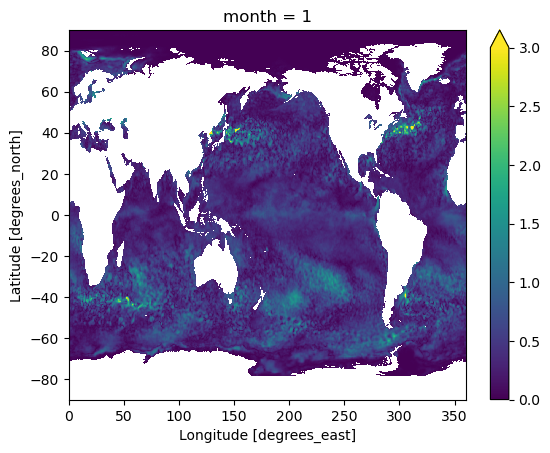

In [14]:
da_mon_quantile.isel(month=0).plot(vmin=0,vmax=3)

## Identify the marine heatwaves based on threshold 
The figure below shows the original SST anomaly value for the first month.

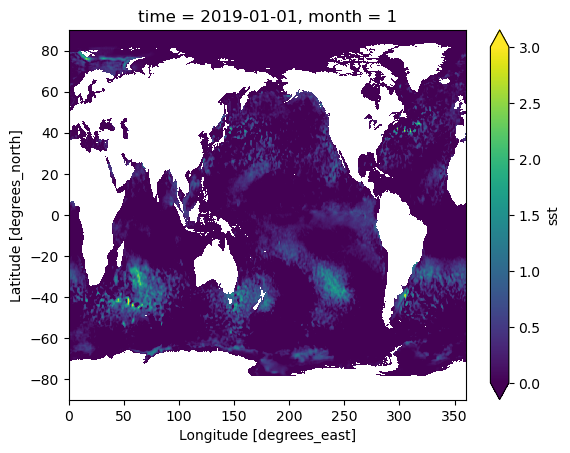

In [15]:
ds_mon_anom.sst.isel(time=0).plot(vmin=0,vmax=3)

To identify the marine heatwaves based on the monthly threshold, we use the `where` method to find the monthly marine heatwaves with the grid that has SST anomaly below the threshold to be masked as Not-a-Number. 

In [16]:
da_mhw = ds_mon_anom.sst.where(ds_mon_anom.sst.groupby('time.month')>da_mon_quantile)

The figure below shows the SST anomalous values that are above the monthly thresholds for the first months.

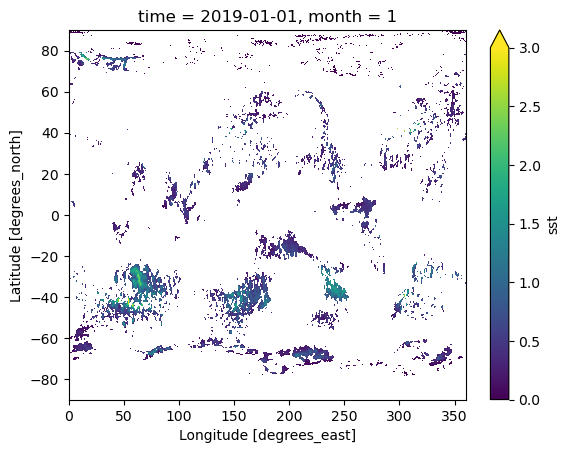

In [17]:
da_mhw.isel(time=0).plot(vmin=0,vmax=3)

---

## Summary
Through this example, we demostrate how to lazily loaded a real world SST data from a OPeNDAP server and calculate the threshold that help us define the marine heatwave. 
By using the threshold, we can find the marine heatwave in each month.


### What's next?
A more interactive figures to view the marine heatwave will be added.
